# Multi Label Classification

In the [previous notebook](BinaryClassification.ipynb) we build a model to do binary classification. In this notebook we are going to build a model to do multi label classification.

## Getting started

We are going to start by importing our base libraries and setting the random seed for reproducibility. 

In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib
import torch.optim as optim

## Data generation

We will use the  ```make_blobs``` function from the ```sklearn.datasets``` module to generate our data. 

In [2]:
# Make 1000 samples
n_samples = 1000

CLASSES = 4
FEATURES = 2
SEED = 12345

# 1. Create multi-class data
x, y = make_blobs(
    n_samples=n_samples,
    n_features=FEATURES,
    centers=CLASSES,
    cluster_std=1.2,
    random_state=SEED,
)

Let's see the dataset 

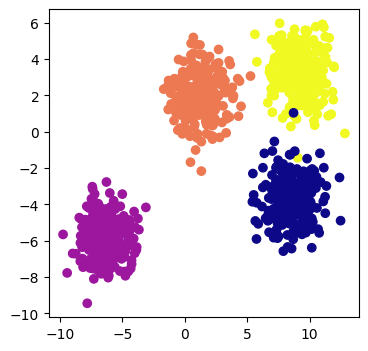

In [3]:
plt.figure(figsize=(4, 4))

plt.scatter(x=x[:, 0], y=x[:, 1], c=y, cmap=plt.cm.plasma);

## Data Preprocessing

We now need to convert our data into tensors and generate our test / train split. We will use the typical 80:20 split for this.

In [4]:
X = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

train_split = int(0.8 * len(X))
X_train = X[:train_split]
X_test = X[train_split:]

y_train = y[:train_split]
y_test = y[train_split:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


## Building a Model

We are going to setup our model in a similar way as before, however this time we have more than one output. To make  it easier to write our forward pass we are going to use the ```torch.nn.Sequential``` class which will call the forward method of each module in the order they are passed to the constructor.

In [5]:
def get_device() -> torch.device:
    """
    Returns the appropriate device for the current environment.
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():  # mac metal backend
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Make device agnostic code
device = get_device()
print(device)

mps


We will still inherit from the nn.Module but change the shape of our model to include a hidden layer with a ReLU activation function.

In [6]:
# Build model with non-linear activation function


class Classify(nn.Module):
    def __init__(self, input_features=2, output_features=1, hidden_size=8):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer(x)


model = Classify(input_features=FEATURES, output_features=CLASSES).to(device)
print(model.parameters)

<bound method Module.parameters of Classify(
  (linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)>


## Loss Function and Optimizer

This time as we are dealing with more than one output we need to use the CrossEntropyLoss function. This is a combination of the softmax activation function and the negative log likelihood loss function.

In [7]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=model.parameters(), lr=0.1)

We can now look at the basic output of the untrained model. 

In [8]:
logits = model(X_train.to(device))
print(logits.shape)
probabilities = torch.softmax(logits, dim=1)
print(logits[:5])
print(probabilities[:5])

torch.Size([800, 4])
tensor([[-0.2483,  0.2822, -0.3031, -0.2975],
        [-0.2372,  0.2851, -0.2476, -0.2466],
        [-0.2656,  0.0129, -0.4234, -0.2593],
        [-0.2447, -0.0754, -0.4302, -0.1985],
        [-0.2604,  0.0630, -0.4287, -0.2734]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2175, 0.3696, 0.2059, 0.2070],
        [0.2143, 0.3613, 0.2121, 0.2123],
        [0.2392, 0.3160, 0.2042, 0.2407],
        [0.2462, 0.2916, 0.2045, 0.2578],
        [0.2373, 0.3279, 0.2005, 0.2342]], device='mps:0',
       grad_fn=<SliceBackward0>)


The softmax function is used to convert the output of the model into a probability distribution, this should sum to 1. We can then find the class with the highest probability using the argmax function to determine the predicted class.

In [9]:
print(probabilities[0])
print(torch.argmax(probabilities[0]))

tensor([0.2175, 0.3696, 0.2059, 0.2070], device='mps:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='mps:0')


In [10]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Training the Model

We will now train the model using the training data. We will use the same training loop as in the previous lab but using the new data sets, we will now also copy the data to the device to help speed up the training process.

In [11]:
torch.manual_seed(1234)

epochs = 100

# copy to device
X_train = X_train.to(device)

# Note we need to convert here as the cuda model doesn't work on floats
y_train = y_train.type(torch.LongTensor)
y_train = y_train.to(device)


X_test = X_test.to(device)
y_test = y_test.type(torch.LongTensor)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_train)
    # turn logits -> pred probs -> pred labls
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred)

    # reset the optimizer to zero
    optimizer.zero_grad()
    # calculate the gradients
    loss.backward()
    # update the weights
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"
        )

Epoch: 0 | Loss: 1.30443, Accuracy: 33.12% | Test loss: 1.17470, Test acc: 43.00%
Epoch: 10 | Loss: 0.64048, Accuracy: 73.25% | Test loss: 0.59508, Test acc: 71.50%
Epoch: 20 | Loss: 0.41732, Accuracy: 76.50% | Test loss: 0.42151, Test acc: 72.00%
Epoch: 30 | Loss: 0.34134, Accuracy: 78.62% | Test loss: 0.35060, Test acc: 74.50%
Epoch: 40 | Loss: 0.29422, Accuracy: 84.25% | Test loss: 0.30392, Test acc: 84.00%
Epoch: 50 | Loss: 0.24918, Accuracy: 91.50% | Test loss: 0.25761, Test acc: 92.00%
Epoch: 60 | Loss: 0.20581, Accuracy: 97.38% | Test loss: 0.21208, Test acc: 98.50%
Epoch: 70 | Loss: 0.16756, Accuracy: 98.25% | Test loss: 0.17136, Test acc: 98.50%
Epoch: 80 | Loss: 0.13733, Accuracy: 97.88% | Test loss: 0.13866, Test acc: 99.00%
Epoch: 90 | Loss: 0.11561, Accuracy: 98.00% | Test loss: 0.11484, Test acc: 99.00%


This is much better accuracy around 80% which is much better than the previous model. Let's make some predictions and see how well the model is doing.

In [12]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.],
         [0., 0., 1., 1.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 1.]], device='mps:0'),
 tensor([0., 0., 3., 3., 3., 2., 1., 3., 1., 0.]))

We can use the same code we used in the previous lab to plot the decision boundary.

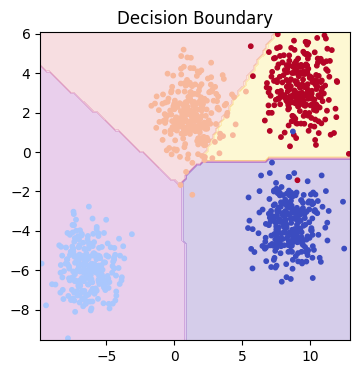

In [13]:
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
plt.figure(figsize=(4, 4))
grid = np.c_[xx.ravel(), yy.ravel()]
# turn the grid into a tensor
grid_tensor = torch.from_numpy(grid).type(torch.float).to(device)
# make predictions on the grid
model.eval()
with torch.inference_mode():
    test_logits = model(grid_tensor).squeeze()
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # reshape the predictions back into the meshgrid shape
    zz = test_preds.reshape(xx.shape).detach().cpu().numpy()
    plt.contourf(xx, yy, zz, cmap=plt.cm.plasma, alpha=0.2)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, s=10, cmap=plt.cm.coolwarm)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Decision Boundary")
    plt.show()

This works well. Try re-running the model with the ReLU activation function removed and see how this affects the decision boundary.